In [4]:
#Filename: equilibrium-ode-solver.ipynb
#Authors: Wing Pok Lee, Jonathan Woo, Luke Triplett, Yifan Gu, Hong Kiat Tan

In [5]:
#Reset Variables
%reset -f

#Packages and Modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.integrate import solve_ivp, simps, cumtrapz
from scipy.optimize import fsolve, curve_fit
from tqdm import tqdm
from labellines import labelLine, labelLines

plt.style.use('seaborn-poster')

#Auto display plots in next cell
%matplotlib inline

C:\Users\jonathan\AppData\Local\Temp\ipykernel_23440\3002164464.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


# Monodisperse Flux Generator for fixed $\alpha$ for DFM and SBM

0) Specify desired angle

1) Solve ODEs for $\tilde{\phi}$ and $\tilde{\sigma}$

1.5) Bifurcation digrams for SBM and DFM

2) Compute fluxes

3) Export flux table

## 0) Specifiy angle (in degrees)

In [6]:
angle=50

## Base Parameters 

In [7]:
#Base Parameters

phi_m = 0.61
rho_l = 971 
mu_l = 10**(-3)*rho_l # dynamic viscosity = kinematic viscosity *density
rho_p = 2475 
rho_s = (rho_p - rho_l)/rho_l
I_0= 0.005
m_1 = 0.32
m_2 = 0.7
Lambda_1=1
Lambda_2 = 0.8

#Effective density
rho = lambda phi: rho_l + (rho_p-rho_l)*phi

## Parameters of Choice; 
alpha = angle*np.pi/180
cot = lambda x: np.cos(x)/np.sin(x)
B_0 = (rho_s/Lambda_2)*cot(alpha)

## Base Parameters
K_v = 0.62
K_c = 0.41
B1 = 2*(K_v - K_c)/K_c
B2 = 2*rho_s*cot(alpha)/(9*K_c)

#SBM helper functions
#1 indicates s-derivative divided by dphi/ds. Example: I1 = (1/phi'(s))*(dI/ds)
I = lambda phi: m_1 +((m_2-m_1)*(phi-phi_m)**2)/((phi-phi_m)**2+I_0*phi**2)
I1 = lambda phi: 2*I_0*phi_m*(m_2-m_1)*phi*(phi-phi_m)/((phi-phi_m)**2+I_0*phi**2)**2
N = lambda phi: (phi/phi_m)**2
N1 = lambda phi: 2*phi/(phi_m**2)
D = lambda phi: (1-phi/phi_m)**2 + 2.5*phi*(1-phi/phi_m)+I(phi)*N(phi)
D1 = lambda phi: (-2/phi_m)*(1-phi/phi_m)+2.5*(1-2*phi/phi_m)+I1(phi)*N(phi)+I(phi)*N1(phi)
R = lambda phi: N(phi)/D(phi)
R1 = lambda phi: (N1(phi)*D(phi)-D1(phi)*N(phi))/(D(phi)**2)

##Viscosities
mu_SBM = lambda phi: (1 + 2.5*(phi/(1-phi/phi_m))+I(phi)*((phi/phi_m)/(1-phi/phi_m))**2)
mu_DFM = lambda phi: 1/((1-phi/phi_m)**2)

mu_SBM_prime = lambda phi: 2.5*(1/(1-phi/phi_m)**2)+I1(phi)*((phi/phi_m)/(1-phi/phi_m))**2+2*I(phi)*((phi/phi_m**2)*(1-phi/phi_m)**2+phi**2/phi_m**3*(1-phi/phi_m))/(1-phi/phi_m)**4

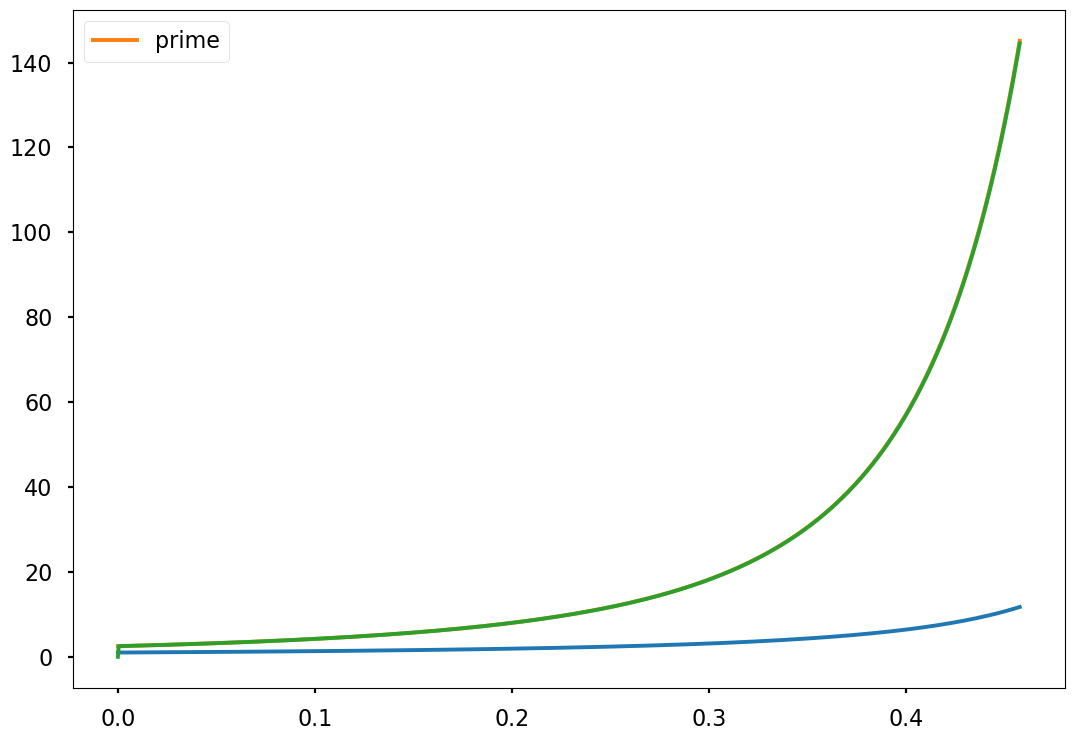

In [8]:
#Sanity check for mu_SBM:
phis=np.linspace(0,phi_m*(3/4),1000)
plt.plot(phis,mu_SBM(phis))
plt.plot(phis,mu_SBM_prime(phis),label='prime')
numerical_deriv = np.zeros(1000)
numerical_deriv[1:] =np.diff(mu_SBM(phis))/np.diff(phis)
plt.plot(phis,numerical_deriv)
plt.legend()

In [9]:
#Critical phis

#SBM crit
const_phi_eq = lambda phi: -(1+rho_s*phi)*R(phi)+B_0*phi
root_left=0
root_right=phi_m
for j in range(0,50):
    root_mid = (root_left + root_right)/2
    if const_phi_eq(root_mid) > 0:
        root_left = root_mid
    if  const_phi_eq(root_mid) <0:
        root_right = root_mid
phi_c_sbm = root_mid

#DFM crit
phi_q = -(B2+1)/(2*rho_s) + np.sqrt((B2+1)**2 + 4*B2*rho_s)/(2*rho_s)
phi_c_dfm =  min([phi_m, phi_q])

print('SBM phi crit: ', phi_c_sbm)
print('DFM phi crit: ', phi_c_dfm)


SBM phi crit:  0.3217504146906287
DFM phi crit:  0.3201527714335035


## 1) ODE Solver

In [10]:
#Solve full SBM equilibrium equations
def full_SBM(phi_0):
    
    ## Update the corresponding flux functions
    G = lambda z,phi,sigma: -(1+rho_s*phi) #dsigma/ds
    F = lambda z,phi,sigma: -(R(phi)*G(z,phi,sigma)+B_0*phi)/(R1(phi)*sigma) if 0 < phi < phi_m else 0 #dphi/ds
    FF = lambda z,para: np.array([F(z,para[0],para[1]),G(z,para[0],para[1])])

    gap = 0.001
    overallrtol = 1e-3
    overallatol = 1e-6
    t_con = 0.8**(1/10)
    t_evalfine = np.concatenate((np.linspace(0,t_con,10001,endpoint=False),np.linspace(0.8,1,40001)**(1/10)))

    sigma0 = 1 + rho_s*phi_0 #sigma(0)
    phi0left = 0
    phi0right = phi_m
    med = 'Radau'
    
    #Bisection method for shooting
    for j in range(0,30):
        phi0mid = 1/2*(phi0left + phi0right)
        sol = solve_ivp(FF, [0, 1], [phi0mid,sigma0], t_eval = t_evalfine, method = med, rtol = overallrtol, atol = overallatol) 
    
        checker = sol.y[1][-1]
        if checker > 0:
            phi0left = phi0mid
        if checker < 0:
            phi0right = phi0mid
            
            
    sol = solve_ivp(FF, [0, 1], [phi0mid,sigma0], t_eval = t_evalfine, method = med, rtol = overallrtol, atol = overallatol)


    phis = sol.y[0]
    sigmas = sol.y[1]
    times = sol.t
    
    return phis, sigmas, times, F, G, phi_c_sbm, mu_SBM

In [11]:
#Solve full SBM equilibrium equations

def full_SBM_shear_rate_corr(phi_0,delta_0=1e-3):
    phis, sigmas, times, F, G, phi_c_sbm, mu_SBM = full_SBM(phi_0)
    sigma_new = lambda phi,sigma: np.sqrt(sigma**2 + delta_0**2*mu_SBM(phi)**2)
    if True:#phi_0 > phi_c_sbm:
        ## Update the corresponding flux functions
        G = lambda z, phi,sigma: -(1+rho_s*phi)
        one = lambda phi,sigma: sigma*(-1-rho_s*phi)/sigma_new(phi,sigma)
        two = lambda phi, sigma: delta_0**2*mu_SBM(phi)*mu_SBM_prime(phi)/sigma_new(phi,sigma)
        F = lambda z, phi, sigma: (-B_0*phi-one(phi,sigma)*R(phi))/(two(phi,sigma)*R(phi)+R1(phi)*sigma_new(phi,sigma)) if 0<phi<phi_m else 0
        FF = lambda z,para: np.array([F(z,para[0],para[1]),G(z,para[0],para[1])])

        gap = 0.001
        overallrtol = 1e-6
        overallatol = 1e-9
        t_con = 0.8**(1/10)
        t_evalfine = np.concatenate((np.linspace(0,t_con,10001,endpoint=False),np.linspace(0.8,1,40001)**(1/10)))
        
        sigma0 = 1 + rho_s*phi_0 #sigma(0)
        phi0left = 0
        phi0right = phi_m
        med = 'Radau'

        #Bisection method for shooting
        for j in range(0,30):
            phi0mid = 1/2*(phi0left + phi0right)
            sol = solve_ivp(FF, [0, 1], [phi0mid,sigma0], t_eval = t_evalfine, method = med, rtol = overallrtol, atol = overallatol) 

            checker = sol.y[1][-1]
            if checker > 0:
                phi0left = phi0mid
            if checker < 0:
                phi0right = phi0mid


        sol = solve_ivp(FF, [0, 1], [phi0mid,sigma0], t_eval = t_evalfine, method = med, rtol = overallrtol, atol = overallatol)


        phis = sol.y[0]
        sigmas = np.sqrt(sol.y[1]**2 + delta_0**2*mu_SBM(phis)**2)
        times = sol.t
    
    return phis, sigmas, times, F, G, phi_c_sbm, mu_SBM

In [12]:
#Solve full DFM equilibrium equations with long time scale
def full_DFM(phi_0):

    ## Update the corresponding flux functions
    F = lambda z,phi,sigma: 1/sigma*(-B2 + (B2+1)*phi + rho_s*phi**2)/(1 + B1*phi/(phi_m - phi))  if 0 < phi < phi_m else 0
    G = lambda z,phi,sigma: -(1+rho_s*phi)
    FF = lambda z,para: np.array([F(z,para[0],para[1]),G(z,para[0],para[1])])
 

    gap = 0.001
    overallrtol = 1e-3
    overallatol = 1e-6
    t_con = 0.8**(1/10)
    t_evalfine = np.concatenate((np.linspace(0,t_con,10001,endpoint=False),np.linspace(0.8,1,40001)**(1/10)))
    sigma0 = 1 + rho_s*phi_0
    phi0left = 0
    phi0right = phi_m
    med = 'Radau'
    for j in range(0,30):
        phi0mid = 1/2*(phi0left + phi0right)
        sol = solve_ivp(FF, [0, 1], [phi0mid,sigma0], t_eval = t_evalfine, method = med, rtol = overallrtol, atol = overallatol)
        
        checker = sol.y[1][-1]
        if checker > 0:
            phi0left = phi0mid
        if checker < 0:
            phi0right = phi0mid
        
    sol = solve_ivp(FF, [0, 1], [phi0mid,sigma0], t_eval = t_evalfine, method = med, rtol = overallrtol, atol = overallatol)

    phis = sol.y[0]
    sigmas = sol.y[1]
    times = sol.t
    
    return phis, sigmas, times, F, G, phi_c_dfm, mu_DFM

## 1.5) Bifurcation Diagrams

In [13]:
#Compare equilibrium solutions between SBM and DFM
def compare_eq_soln(phi_0,xlim1=0,xlim2=1.1,ylim1=0.5,ylim2=phi_m,newfig=True):
    sbm_soln = full_SBM(phi_0)
    sbm_soln2 = full_SBM_shear_rate_corr(phi_0)
    dfm_soln = full_DFM(phi_0)
    
    
    phis_sbm = sbm_soln[0]
    sigmas_sbm = sbm_soln[1]
    times_sbm = sbm_soln[2]
    
    phis_sbm2 = sbm_soln2[0]
    sigmas_sbm2 = sbm_soln2[1]
    times_sbm2 = sbm_soln2[2]
    
    
    phis_dfm = dfm_soln[0]
    sigmas_dfm = dfm_soln[1]
    times_dfm = dfm_soln[2]
    
    
    #Plot phis
    if newfig:
        plt.figure(figsize = (10, 8))
   
    plt.plot(times_sbm, phis_sbm, color = 'black', label=r'$\tilde{\phi}_{SB}$')
    plt.plot(times_sbm2, phis_sbm2, color = 'red', label=r'$\tilde{\phi}_{SB shear rate corr}$')
    plt.plot(times_dfm, phis_dfm, color = 'blue', ls='dotted', label=r'$\tilde{\phi}_{DF}$')
    plt.xlabel('$s$',fontsize=25)
    plt.ylabel(r'$\tilde{\phi}$',fontsize=25)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.xlim(xlim1,xlim2)
    plt.ylim(ylim1,ylim2)

    plt.title(r'$\phi_0=$'+str(phi_0))
    plt.legend()
    
    #Plot sigmas
    plt.figure(figsize = (10, 8))
   
    plt.plot(times_sbm, sigmas_sbm, color = 'black', label=r'$\tilde{\sigma}_{SB}$')
    plt.plot(times_sbm2, sigmas_sbm2, color = 'red', label=r'$\tilde{\sigma}_{SB shear rate corr}$')
    plt.plot(times_dfm, sigmas_dfm, color = 'blue', ls='dotted', label=r'$\tilde{\sigma}_{DF}$')
    plt.xlabel('$s$',fontsize=25)
    plt.ylabel(r'$\tilde{\sigma}$',fontsize=25)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.xlim(xlim1,xlim2)
    plt.ylim(ylim1,ylim2)

    plt.title(r'$\phi_0=$'+str(phi_0))
    plt.legend()
        
        

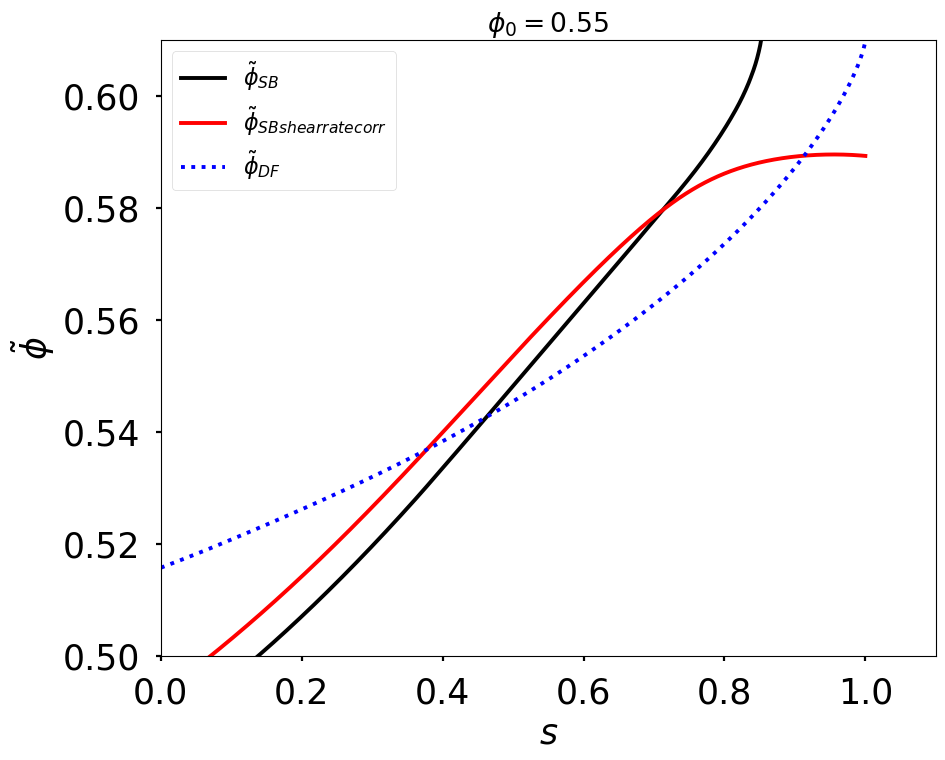

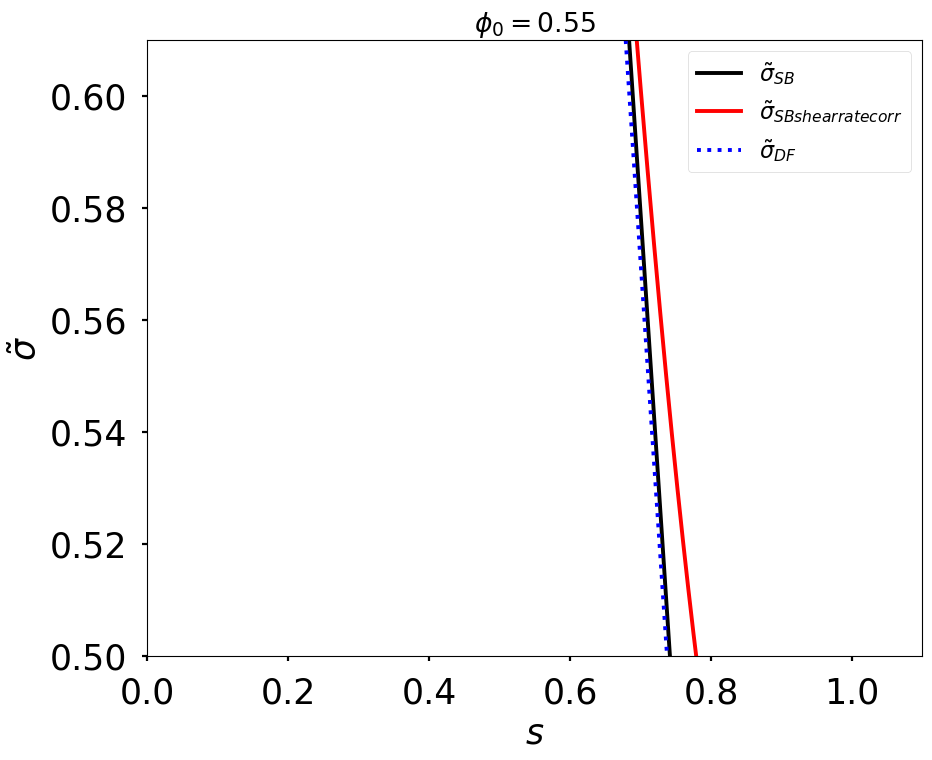

In [14]:
#Samples
compare_eq_soln(0.55)

In [15]:
#Generate bifurcation plots for phi of a given model
def bifurcation_diag(model,index_start,sample_points,xlim1=0,xlim2=1,ylim1=0,ylim2=0.61, titleStr='',fs=45):
    fig, ax = plt.subplots(dpi=300)
    ax.set_xlabel(r'$s$', fontsize=fs)
    ax.set_ylabel(r'$\tilde{\phi}$', fontsize=fs)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    
    plot_crit_phi = True
    
    for i in tqdm(sample_points):
        
        phi_0 = i/1000
        f = model(phi_0)
        phi_crit = f[-2]
        
        plot_color = 'blue' if phi_0<phi_crit else 'black'
        
        label = r'$\phi_0=$'
        ax.plot(f[2], f[0], color=plot_color,linewidth=3,label=label+str(phi_0))
        
        if plot_crit_phi:
            plot_crit_phi =False
            phi_crit = [f[5],f[5]]
            interval = [0,1]
            plt.title(titleStr,fontsize=fs)
            plt.plot(interval, phi_crit, color='red',linewidth=3,ls='dashed',label=r'$\phi_0=$'+str(round(phi_crit[0],2)))
        
    plt.ylim(ylim1,ylim2)
    plt.xlim(xlim1,xlim2)
    
    labelLines(ax.get_lines(),zorder=2.5,outline_width=15,xvals=[0.3,0.3,0.5,0.7,0.5], fontsize=fs)
    blue_line = mlines.Line2D([], [], color='blue',markersize=15, label='Settled')
    black_line = mlines.Line2D([], [], color='black',markersize=15, label='Ridged')
    red_line = mlines.Line2D([], [], color='red', ls='dotted',markersize=15, label='Well-Mixed')
    #plt.legend(handles=[blue_line, red_line,black_line],fontsize=fs,loc=1)
    #plt.plot([],[],color='blue', label='Settled')
    #plt.plot([],[], color='black',label='Ridged')
    #plt.legend(fontsize=25)
    

In [16]:
def generate_phi_bifurc(sample_points, xlim1=0,xlim2=1,ylim1=0,ylim2=0.61):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Bifurcation of ' +r'$\tilde{\phi}$'+' for '+ r'$\alpha = $'+str(angle)+r'$^\circ$',fontsize=25)
    ax1.set(title='Suspesion Balance', ylabel=r'$\tilde{\phi}_{crit}$', xlabel=r'$s$', xlim=(xlim1,xlim2),ylim=(ylim1,ylim2))
    ax2.set(title='Diffusive Flux',ylabel=r'$\tilde{\phi}_{crit}$', xlabel=r'$s$',xlim=(xlim1,xlim2),ylim=(ylim1,ylim2))
    plot_crit = True
    for i in tqdm(sample_points):
        phi_0 = i/1000
        f_SBM = full_SBM(phi_0)
        f_DFM = full_DFM(phi_0)
        ax1.plot(f_SBM[2], f_SBM[0],color='black',linewidth=3)
        ax2.plot(f_DFM[2], f_DFM[0],color='black',linewidth=3)
        if plot_crit:
            plot_crit = False
            phi_crit_SBM = [f_SBM[5],f_SBM[5]]
            phi_crit_DFM = [f_DFM[5],f_DFM[5]]
            interval=[0,1]
            ax1.plot(interval,phi_crit_SBM, color='red',linewidth=3,ls='dashed')
            ax2.plot(interval,phi_crit_DFM, color='red',linewidth=3,ls='dashed')
        
        


100%|██████████| 4/4 [00:01<00:00,  2.27it/s]


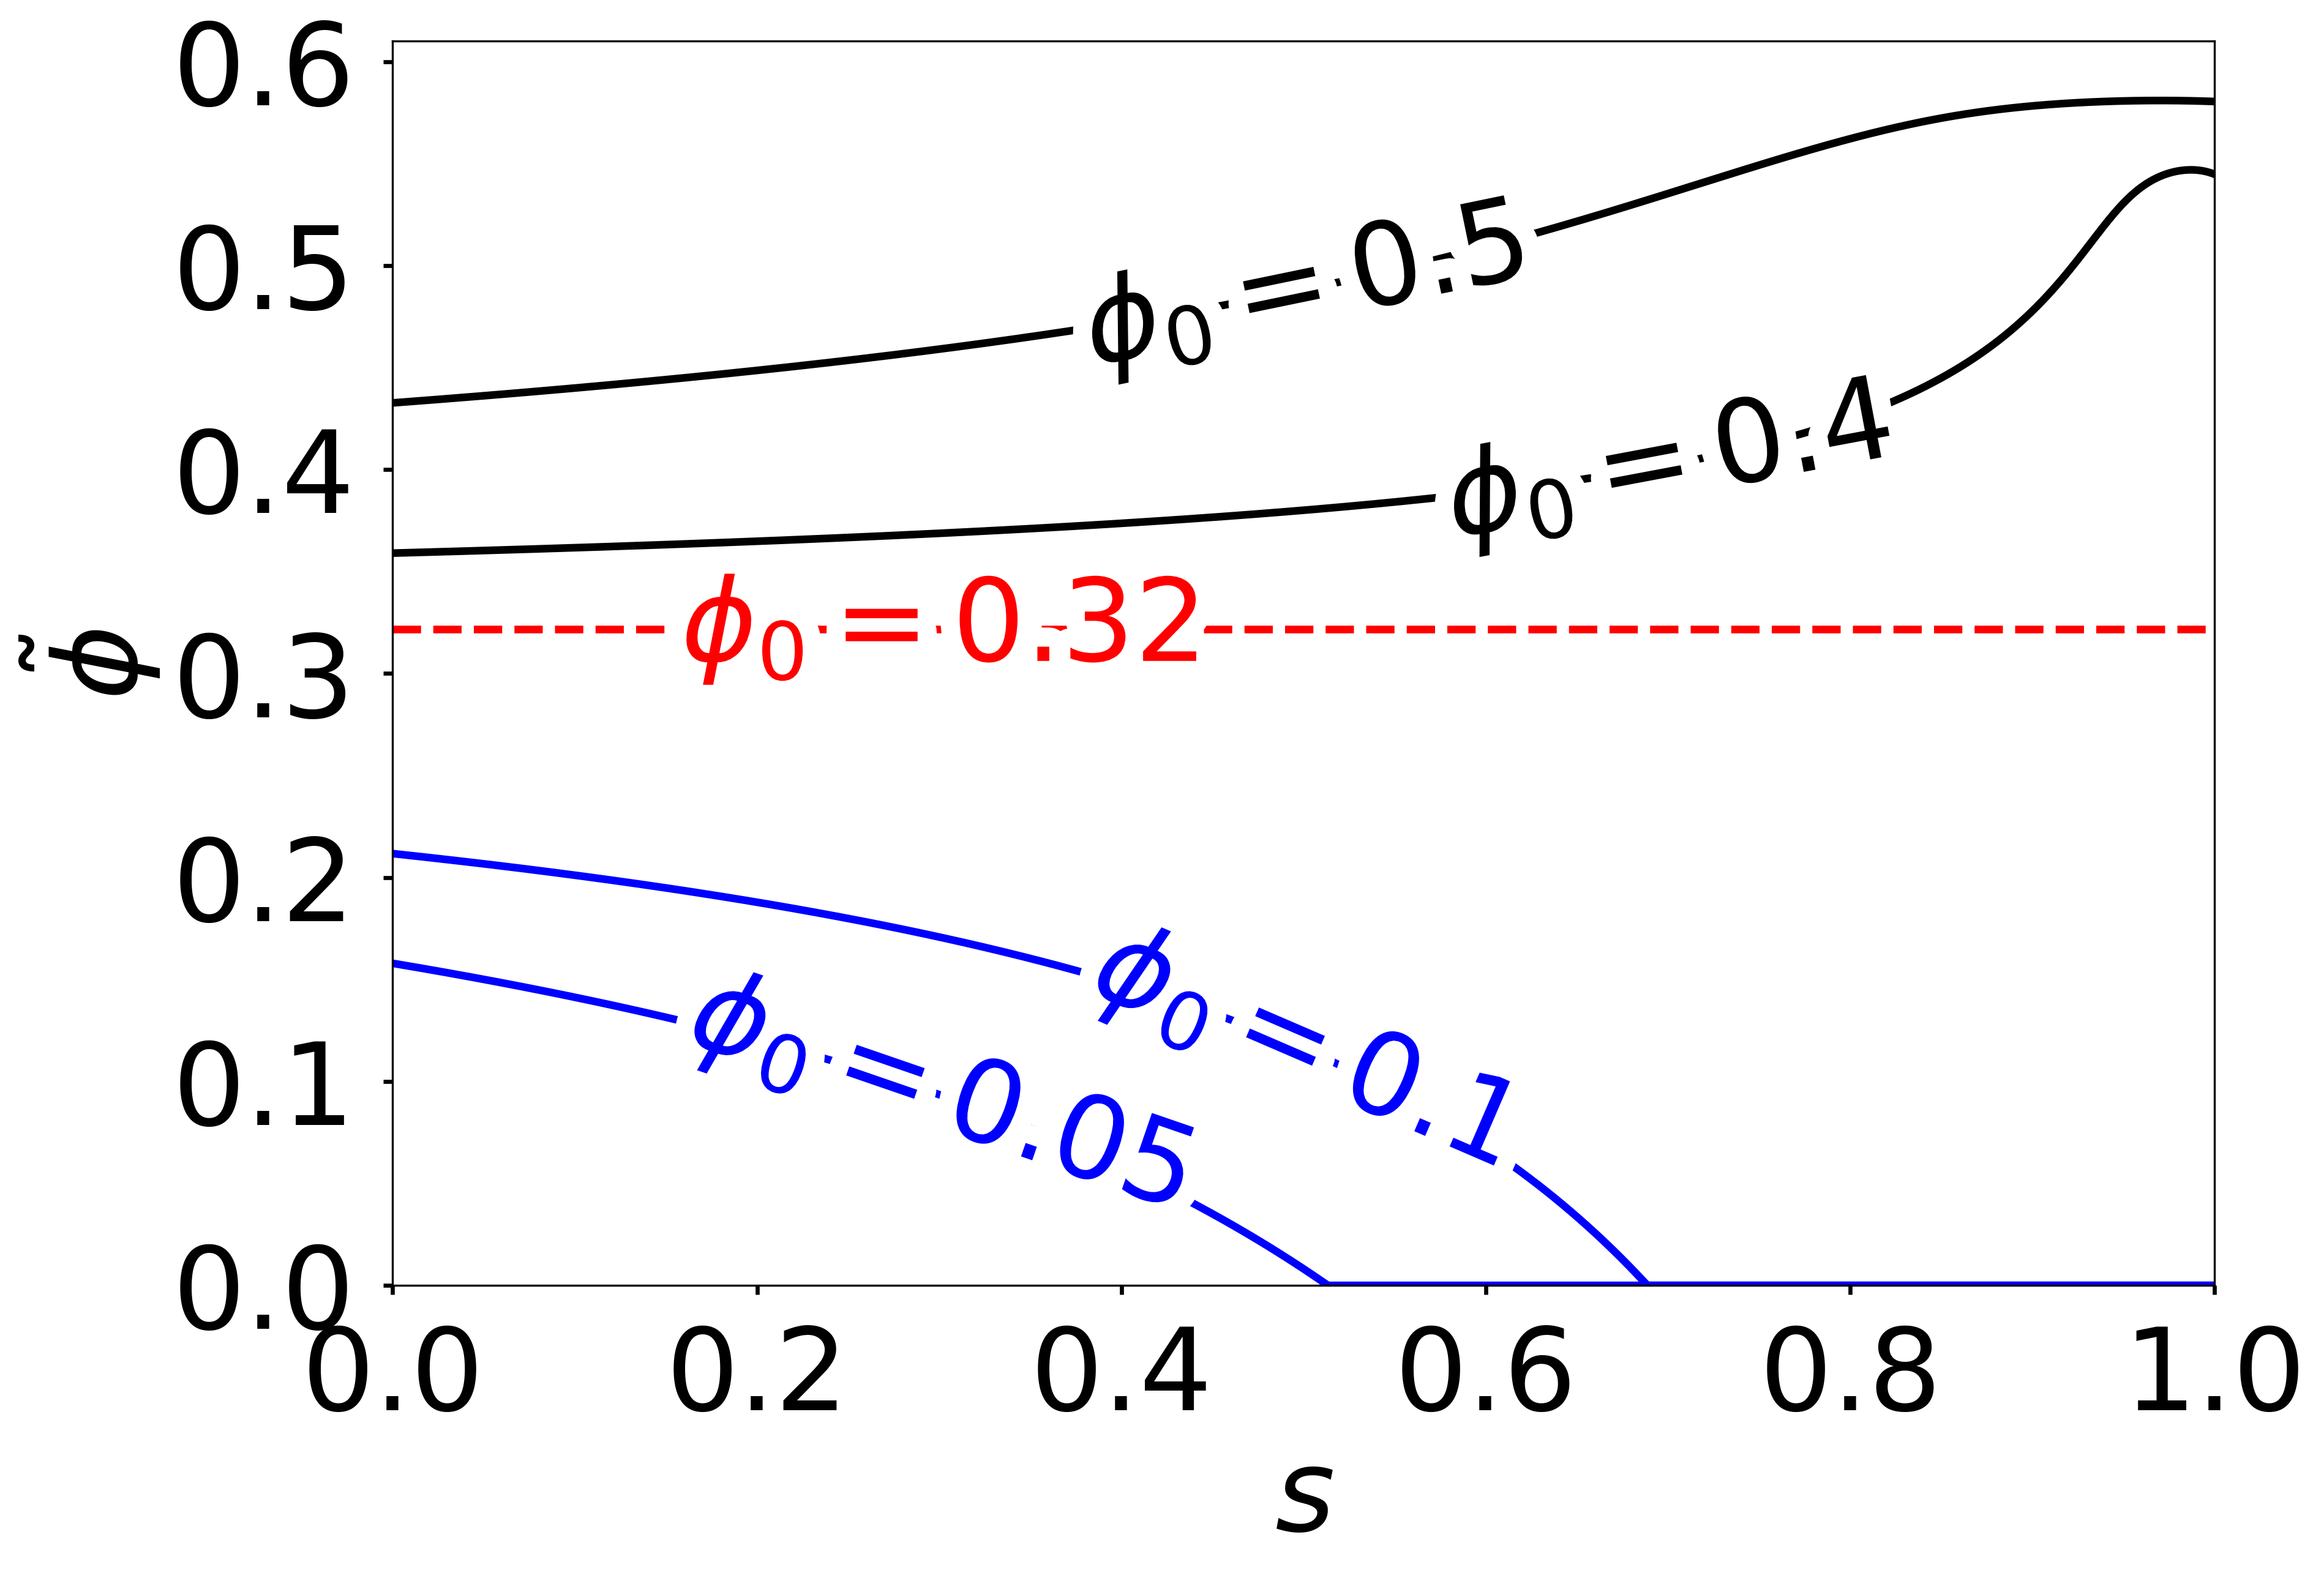

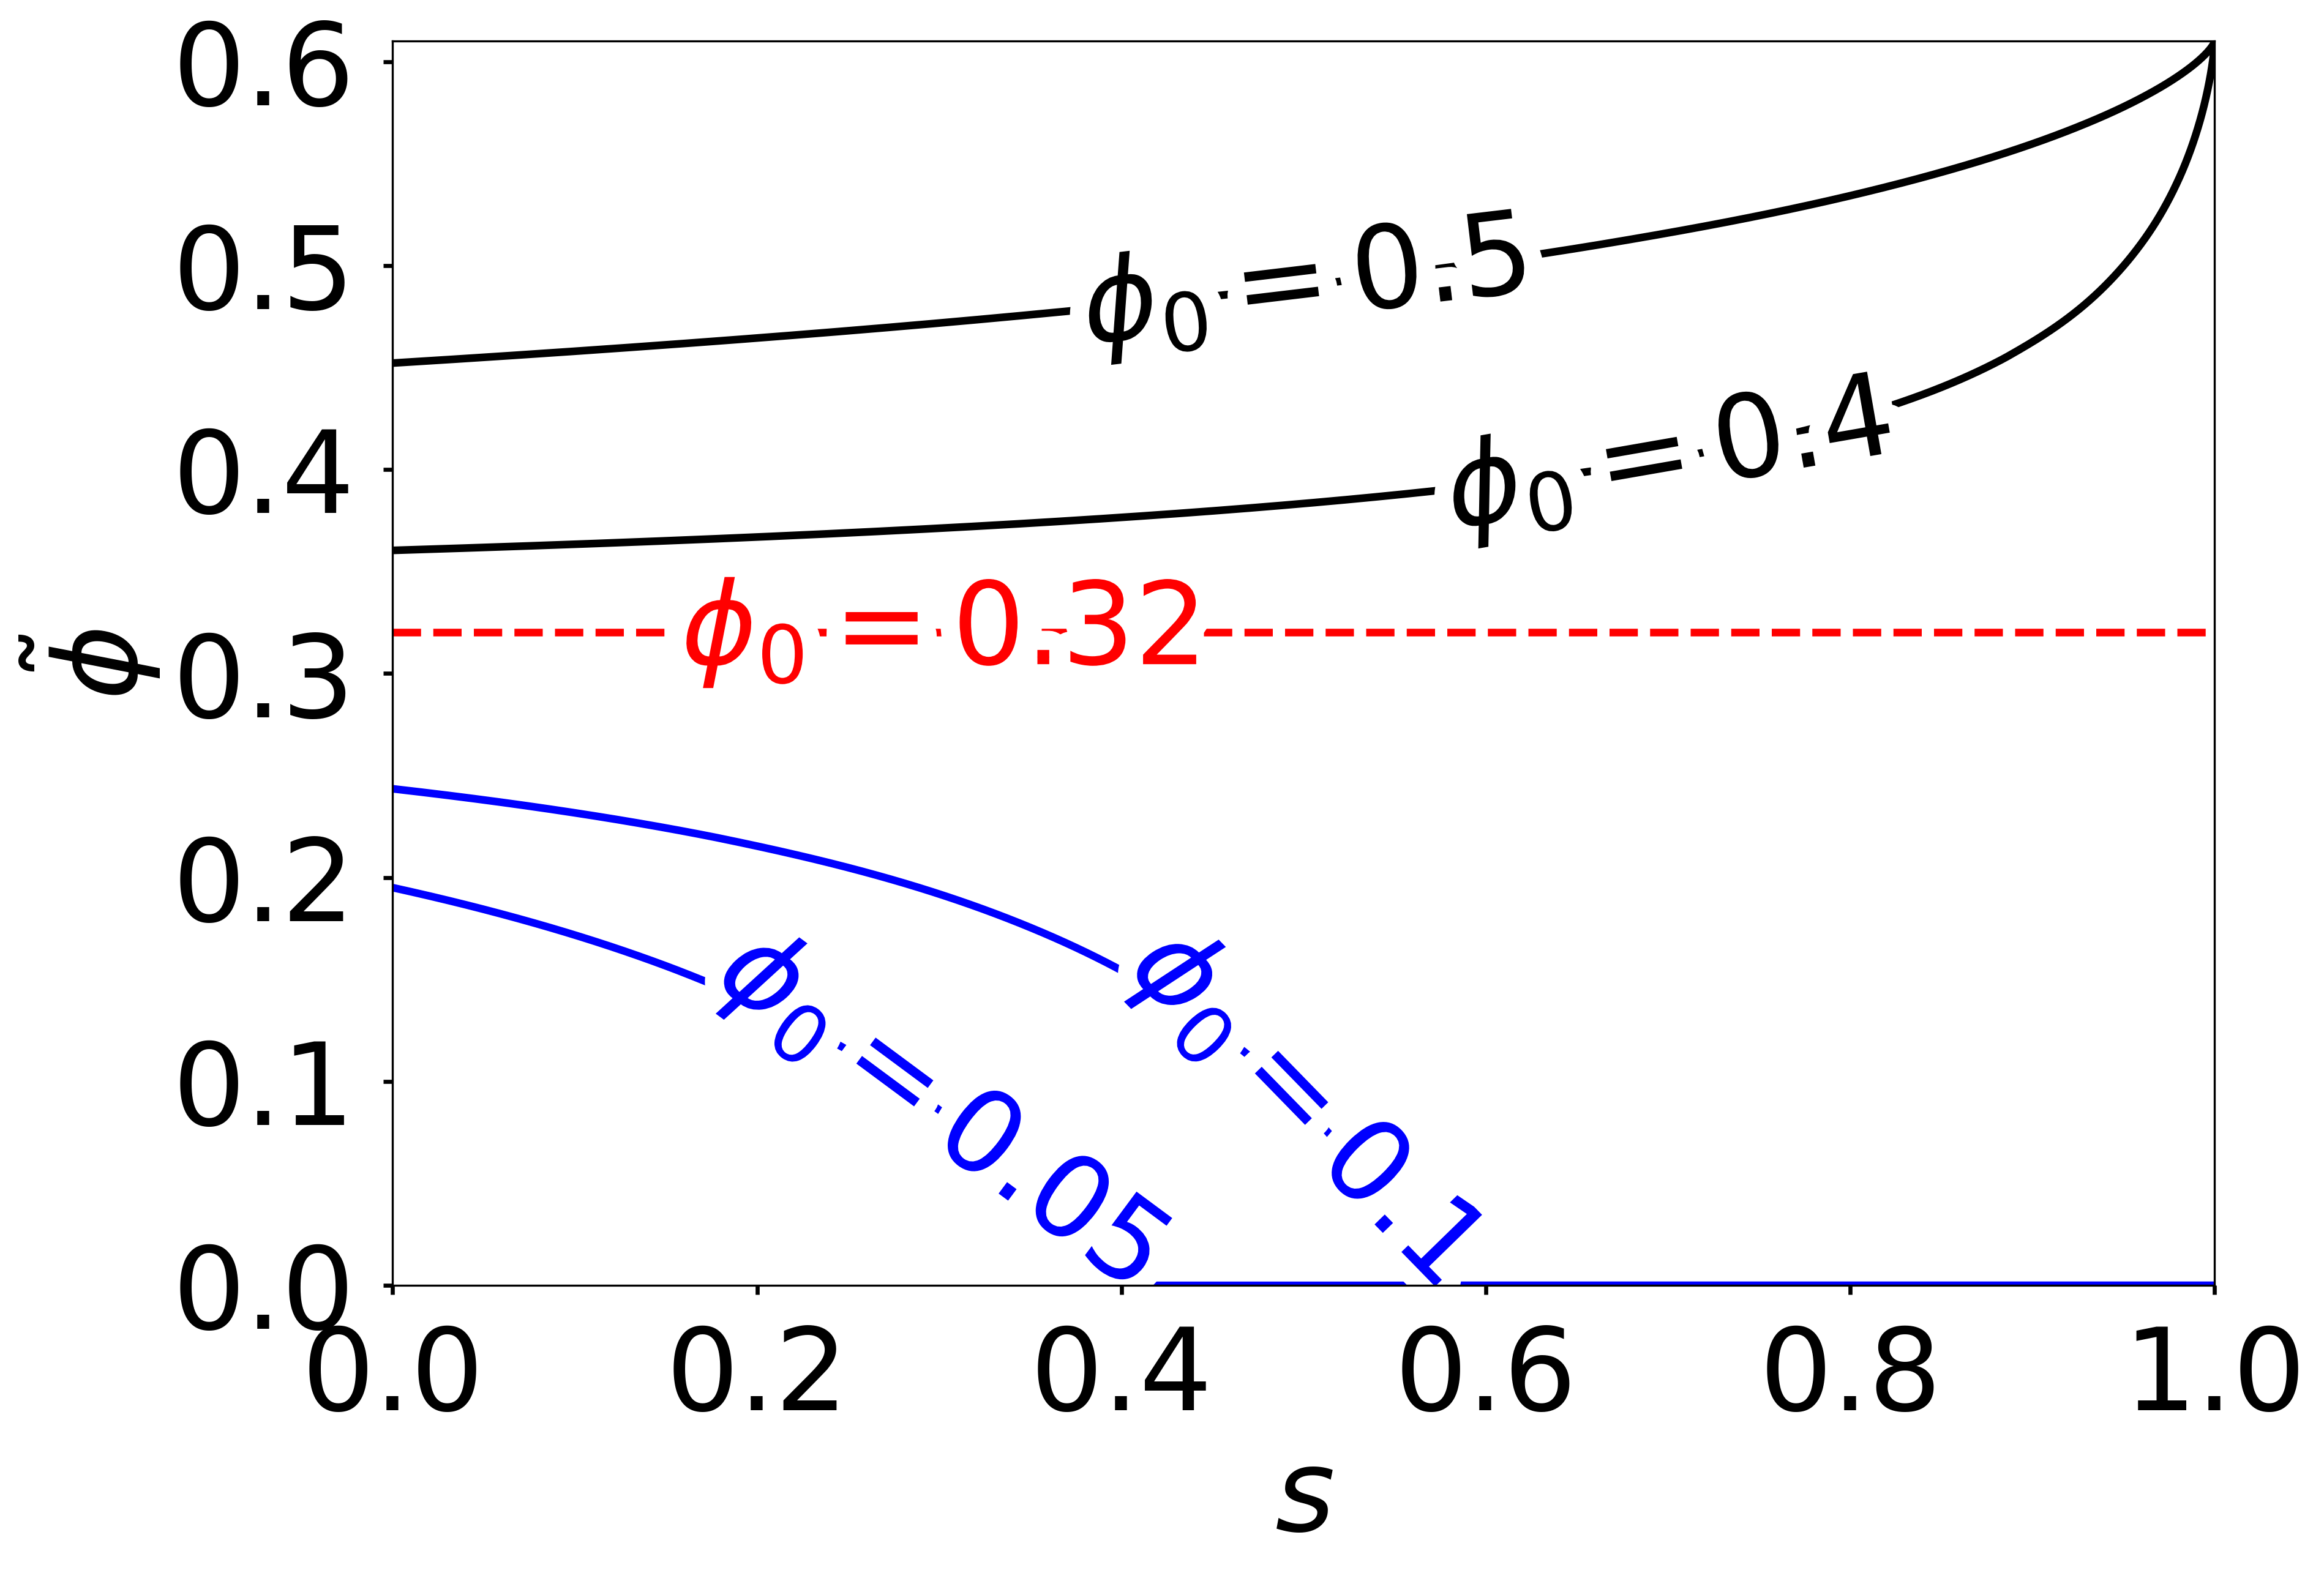

In [17]:
sample_points= [50,100, 400, 500]#[100,175,250,400,475, 550]
bifurcation_diag(full_SBM_shear_rate_corr, 0,sample_points)
#bifurcation_diag(full_SBM,0,sample_points)
bifurcation_diag(full_DFM,0,sample_points)

In [18]:
#Get nondimensionalized velocity
def get_u(mu,phis,sigmas,times):
    
    mus = mu(phis)
    integrands = [sigmas[k]/mus[k] for k in range(len(times))]
    
    #compute integrals
    return np.append([0],cumtrapz(integrands, times))

In [19]:
#Generate bifurcation plots of u for a given model
def bifurcation_u(model,index_start,sample_points,xlim1=0,xlim2=1,ylim1=0,ylim2=0.42,titleStr='',fs=45):
    fig, ax = plt.subplots(dpi=300)
    ax.set_xlabel(r'$s$', fontsize=fs)
    ax.set_ylabel(r'$\tilde{u}$', fontsize=fs)
    ax.set_yticks([0.0,0.1,0.2,0.3,0.4])
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    
    plt.title(titleStr, fontsize=fs)
    plot_crit_phi = True
    
    for i in tqdm(sample_points):
        
        phi_0 = i/1000
        f = model(phi_0)
        phi_crit = f[-2]
        plot_color = 'blue' if phi_0<phi_crit else 'black'
        
        label = r'$\phi_0=$'
        
        ax.plot(f[2], get_u(f[-1],f[0],f[1],f[2]), color=plot_color,linewidth=3, label=label+str(phi_0))
        
        if plot_crit_phi:
            plot_crit_phi = False
            phi_crit = f[5]
            times=f[2]
            phis = np.array([phi_crit for k in range(len(f[0]))])
            sigmas = np.array([-(1+rho_s*phi_crit)*times[k]+(1+rho_s*phi_crit) for k in range(len(f[0]))])
            plt.plot(f[2], get_u(f[-1],phis,sigmas,f[2]), color='red',linewidth=3,ls='dashed', label=label+str(round(phi_crit,2)))
        
    plt.ylim(ylim1,ylim2)
    plt.xlim(xlim1,xlim2)
    labelLines(ax.get_lines(),zorder=2.5, outline_width=15,xvals=[0.7,0.5,0.5,0.6,0.8],fontsize=fs)
    blue_line = mlines.Line2D([], [], color='blue',markersize=15, label='Settled')
    black_line = mlines.Line2D([], [], color='black',markersize=15, label='Ridged')
    red_line = mlines.Line2D([], [], color='red', ls='dotted',markersize=15, label='Well-Mixed')
    #plt.legend(handles=[blue_line, red_line,black_line],fontsize=fs)
    #plt.plot([],[],color='blue', label='Settled')
    #plt.plot([],[], color='black',label='Ridged')
    #plt.legend(fontsize=25)

In [20]:
def generate_u_bifurc(sample_points, xlim1=0,xlim2=1,ylim1=0,ylim2=0.42):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Bifurcation of ' +r'$\tilde{u}$'+' for '+ r'$\alpha = $'+str(angle)+r'$^\circ$',fontsize=25)
    ax1.set(title='Suspesion Balance', ylabel=r'$\tilde{\phi}_{crit}$', xlabel=r'$s$', xlim=(xlim1,xlim2),ylim=(ylim1,ylim2))
    ax2.set(title='Diffusive Flux',ylabel=r'$\tilde{\phi}_{crit}$', xlabel=r'$s$',xlim=(xlim1,xlim2),ylim=(ylim1,ylim2))
    plot_crit = True
    for i in tqdm(sample_points):
        phi_0 = i/1000
        f_SBM = full_SBM(phi_0)
        f_DFM = full_DFM(phi_0)
        ax1.plot(f_SBM[2], get_u(f_SBM[-1],f_SBM[0],f_SBM[1],f_SBM[2]),color='black',linewidth=3)
        ax2.plot(f_DFM[2], get_u(f_DFM[-1],f_DFM[0],f_DFM[1],f_DFM[2]),color='black',linewidth=3)
        if plot_crit:
            plot_crit = False
            phi_crit_SBM = f_SBM[5]
            times_SBM=f_SBM[2]
            phis_SBM = np.array([phi_crit_SBM for k in range(len(f_SBM[0]))])
            sigmas_SBM = np.array([-(1+rho_s*phi_crit_SBM)*times_SBM[k]+(1+rho_s*phi_crit_SBM) for k in range(len(f_SBM[0]))])
            ax1.plot(f_SBM[2], get_u(f_SBM[-1],phis_SBM,sigmas_SBM,f_SBM[2]), color='red',linewidth=3,ls='dashed')
            
            phi_crit_DFM = f_DFM[5]
            times_DFM=f_DFM[2]
            phis_DFM = np.array([phi_crit_DFM for k in range(len(f_DFM[0]))])
            sigmas_DFM = np.array([-(1+rho_s*phi_crit_DFM)*times_DFM[k]+(1+rho_s*phi_crit_DFM) for k in range(len(f_DFM[0]))])
            ax2.plot(f_DFM[2], get_u(f_DFM[-1],phis_DFM,sigmas_DFM,f_DFM[2]), color='red',linewidth=3,ls='dashed')
        
        


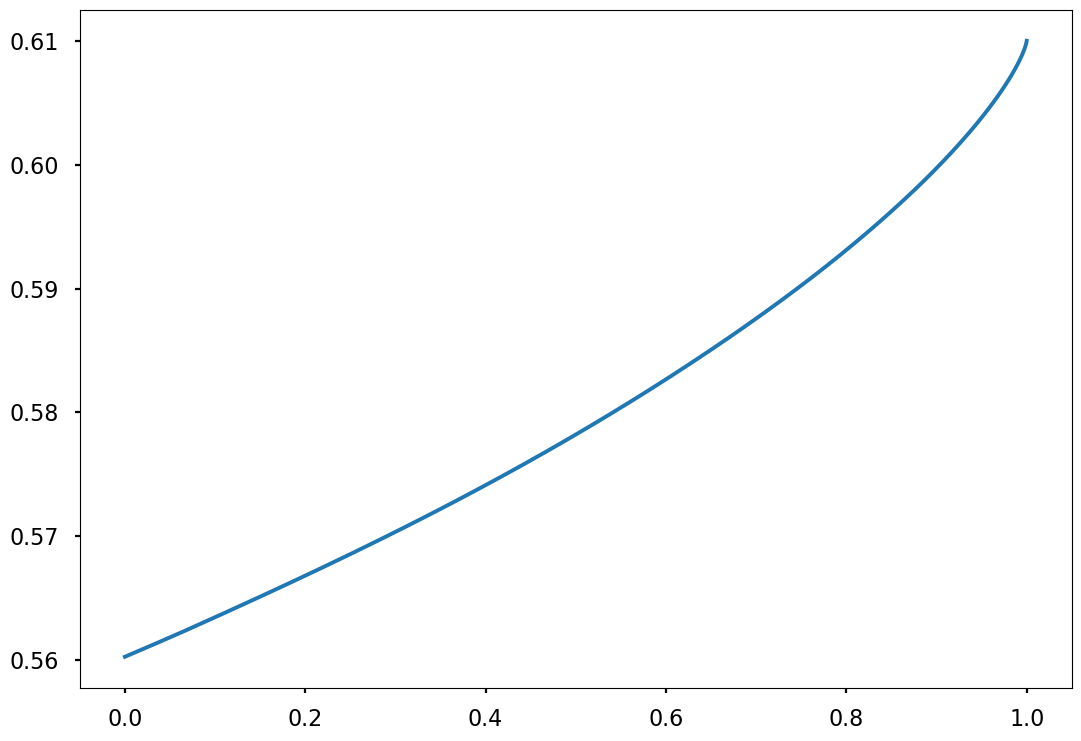

In [21]:
#Checking smoothness of integrands
phis, sigmas, times, F, G, phi_c_sbm, mu_DFM = full_DFM(0.58)
us = get_u(mu_SBM,phis,sigmas,times)
plt.plot(times, phis)

## 2) Compute Fluxes

In [22]:
#Generate Suspension and Particle fluxes
def get_fluxes(model, show_plots=True):
    f_s = []
    g_s = []
    eps = 1e-8
    phi0s = np.arange(0,611)*0.001
    
    for phi_0 in tqdm(phi0s):
        sol= model(phi_0)
        u = get_u(sol[-1],sol[0],sol[1],sol[2])
        times = sol[2]
        g_s = np.append(g_s,simps(u[sol[0]>eps]*sol[0][sol[0]>eps],times[sol[0]>eps]))
        f_s = np.append(f_s,simps(u,times))
    
    if(show_plots):
        plt.figure(figsize = (10, 8))
        plt.plot(phi0s,f_s,color='black')
        plt.xlabel(r'$\phi_0$',fontsize=25)
        plt.ylabel(r'$f(\phi_0)$', fontsize=25)
        
        plt.figure(figsize = (10, 8))
        plt.plot(phi0s,g_s, color='black')
        plt.xlabel(r'$\phi_0$',fontsize=25)
        plt.ylabel(r'$g(\phi_0)$', fontsize=25)
        
    return f_s,g_s,phi0s
        

100%|██████████| 611/611 [07:34<00:00,  1.35it/s]


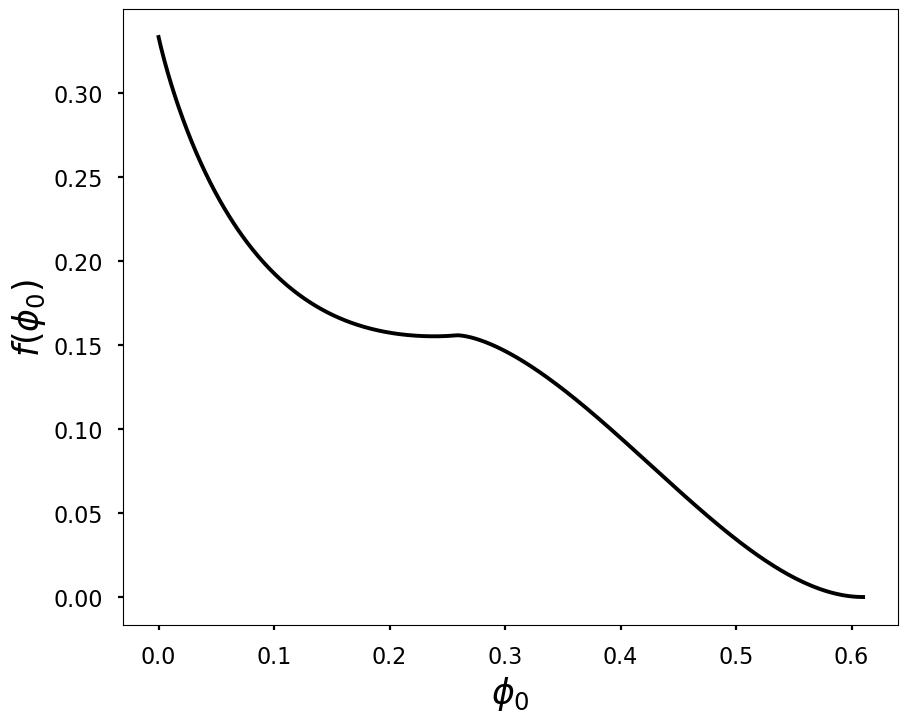

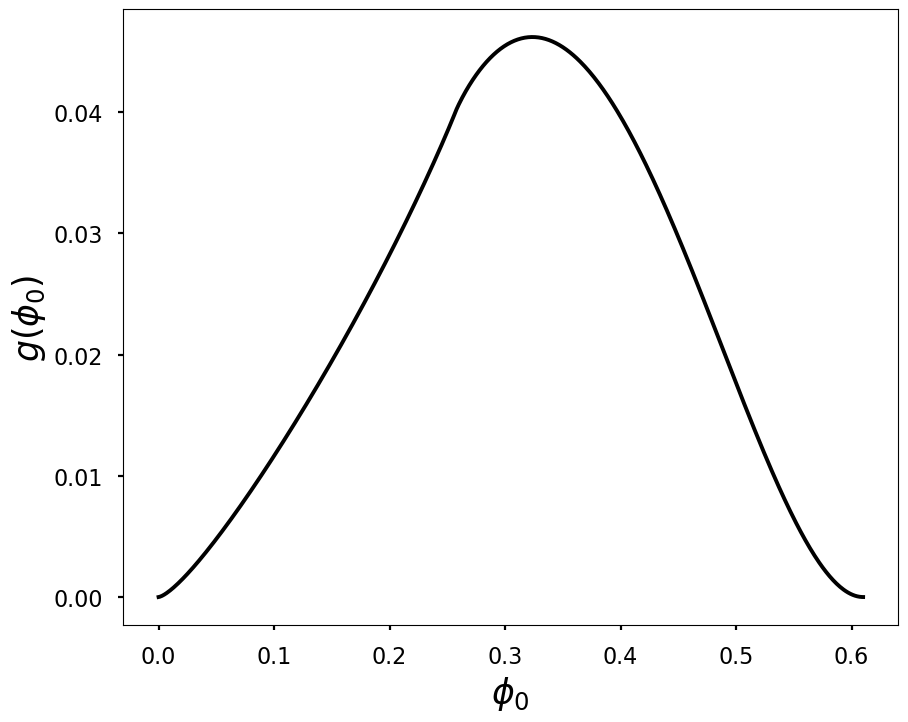

In [55]:
fluxes_DFM = get_fluxes(full_DFM)

100%|██████████| 611/611 [08:48<00:00,  1.16it/s]


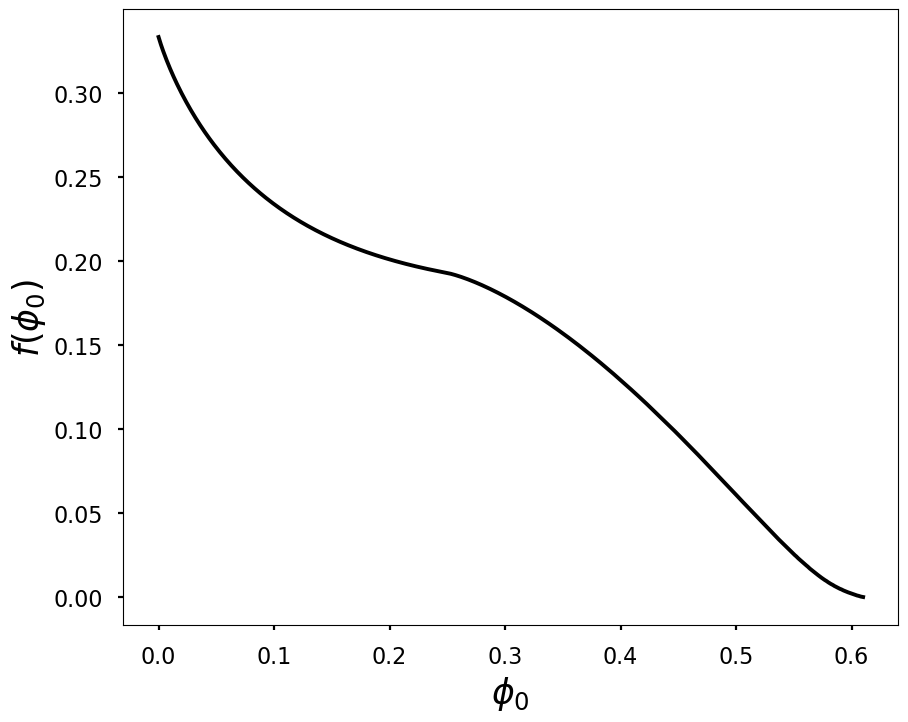

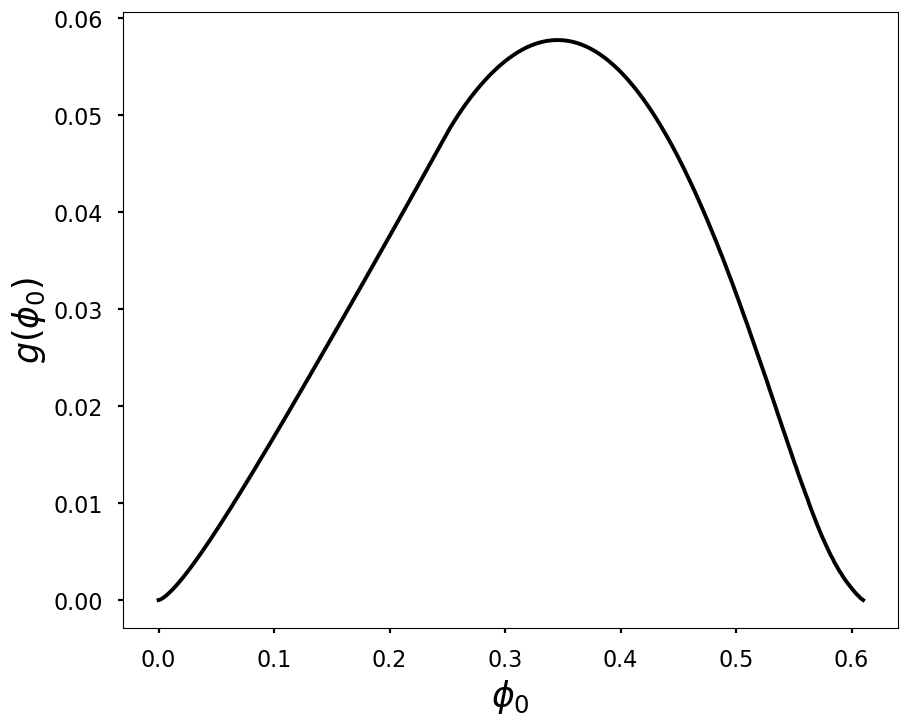

In [56]:
fluxes_SBM =get_fluxes(full_SBM)

100%|██████████| 611/611 [30:57<00:00,  3.04s/it]


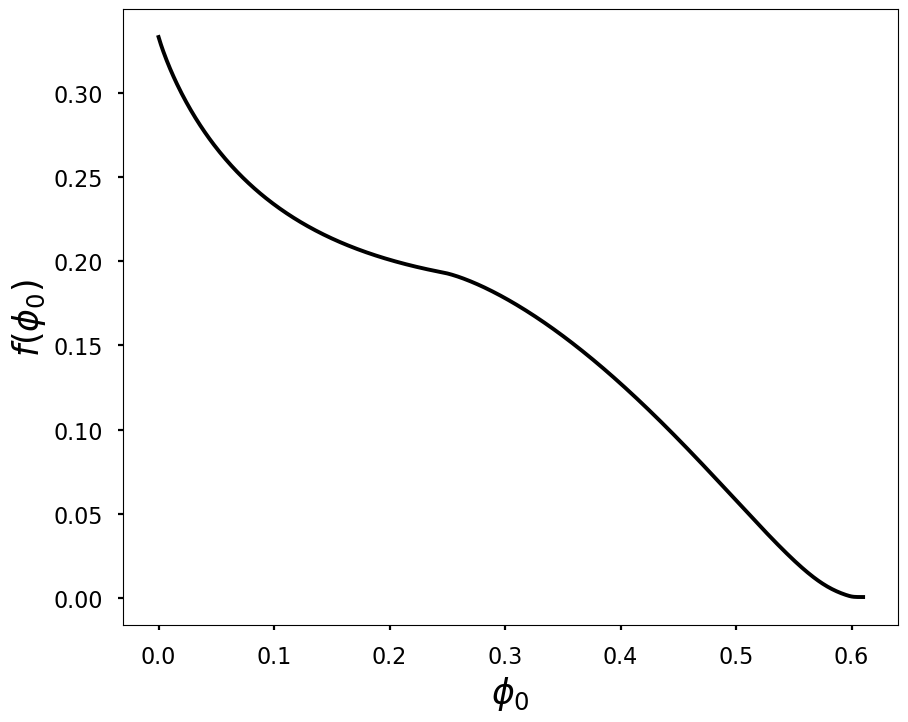

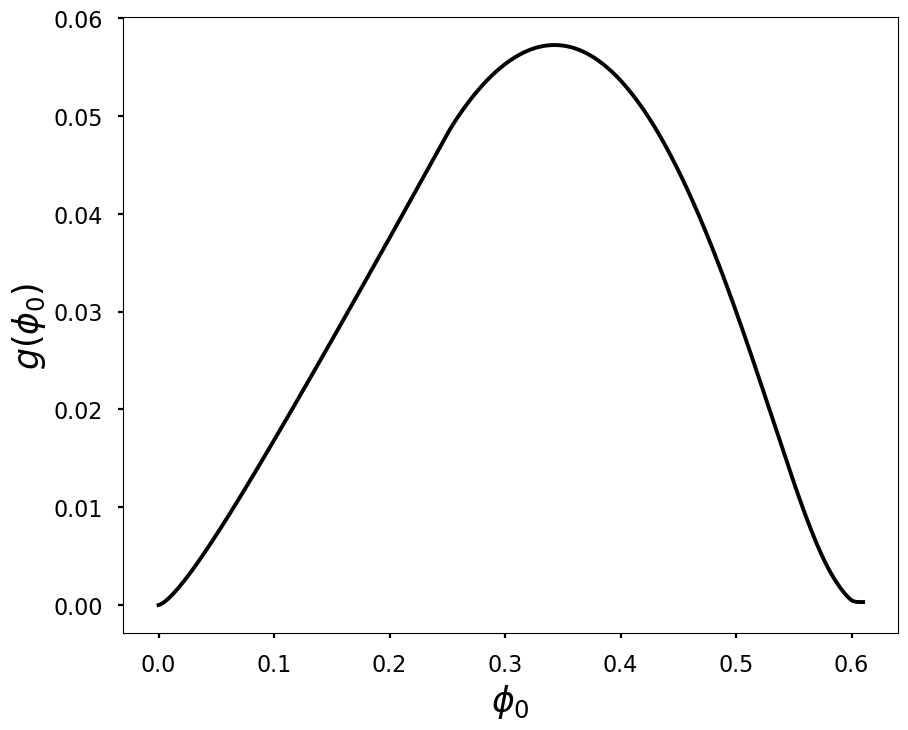

In [57]:
fluxes_SBM_shear_rate_corr = get_fluxes(full_SBM_shear_rate_corr)

## 3) Export fluxes  (as binary file)

Naming convention: (dfm/sbm)_(f/g)_angle 

e.g., sbm_f_20

### Please specify the existing directory you wish to export to (include last /):
### A subdirectory named 'angle#' will be created

In [58]:
dir_path = 'flux_tables/'

### Warning: files will be overwritten

In [59]:
import pickle, os

path = dir_path +'angle'+str(angle)+'/'

try:
    os.mkdir(path)
except:
    print('Directory exists:', path)

f_sbm_name = "sbm_f_"+str(angle)
g_sbm_name = "sbm_g_"+str(angle)
f_dfm_name = "dfm_f_"+str(angle)
g_dfm_name = "dfm_g_"+str(angle)

with open(path+f_sbm_name, "wb") as f:
    pickle.dump(fluxes_SBM[0], f)
with open(path+g_sbm_name, "wb") as g:
    pickle.dump(fluxes_SBM[1], g)
with open(path+f_dfm_name, "wb") as f:
    pickle.dump(fluxes_DFM[0], f)
with open(path+g_dfm_name, "wb") as g:
    pickle.dump(fluxes_DFM[1], g)


Directory exists: flux_tables/angle60/


In [60]:
import pickle, os

path = dir_path +'angle'+str(angle)+'/'

try:
    os.mkdir(path)
except:
    print('Directory exists:', path)

f_sbm_name = "sbm_f_corr"+str(angle)
g_sbm_name = "sbm_g_corr"+str(angle)

with open(path+f_sbm_name, "wb") as f:
    pickle.dump(fluxes_SBM_shear_rate_corr[0], f)
with open(path+g_sbm_name, "wb") as g:
    pickle.dump(fluxes_SBM_shear_rate_corr[1], g)


Directory exists: flux_tables/angle60/


## Accurate computation of fluxes at $\phi_{crit}$

In [61]:
#Generate Suspension and Particle fluxes
def compute_critical_fluxes(model, phi_crit,show_plots=True):
    f_s = []
    g_s = []
    eps = 1e-8
    
    start_node = phi_crit - 50*0.001
    phi0s = start_node+ np.arange(0,100)*0.001
    
    for phi_0 in tqdm(phi0s):
        sol= model(phi_0)
        u = get_u(sol[-1],sol[0],sol[1],sol[2])
        times = sol[2]
        g_s = np.append(g_s,simps(u[sol[0]>eps]*sol[0][sol[0]>eps],times[sol[0]>eps]))
        f_s = np.append(f_s,simps(u,times))
    
    if(show_plots):
        plt.figure(figsize = (10, 8))
        plt.plot(phi0s,f_s,color='black')
        plt.xlabel(r'$\phi_0$',fontsize=25)
        plt.ylabel(r'$f(\phi_0)$', fontsize=25)
        
        plt.figure(figsize = (10, 8))
        plt.plot(phi0s,g_s, color='black')
        plt.xlabel(r'$\phi_0$',fontsize=25)
        plt.ylabel(r'$g(\phi_0)$', fontsize=25)
        
    return f_s,g_s,phi0s
        

100%|██████████| 100/100 [01:45<00:00,  1.05s/it]


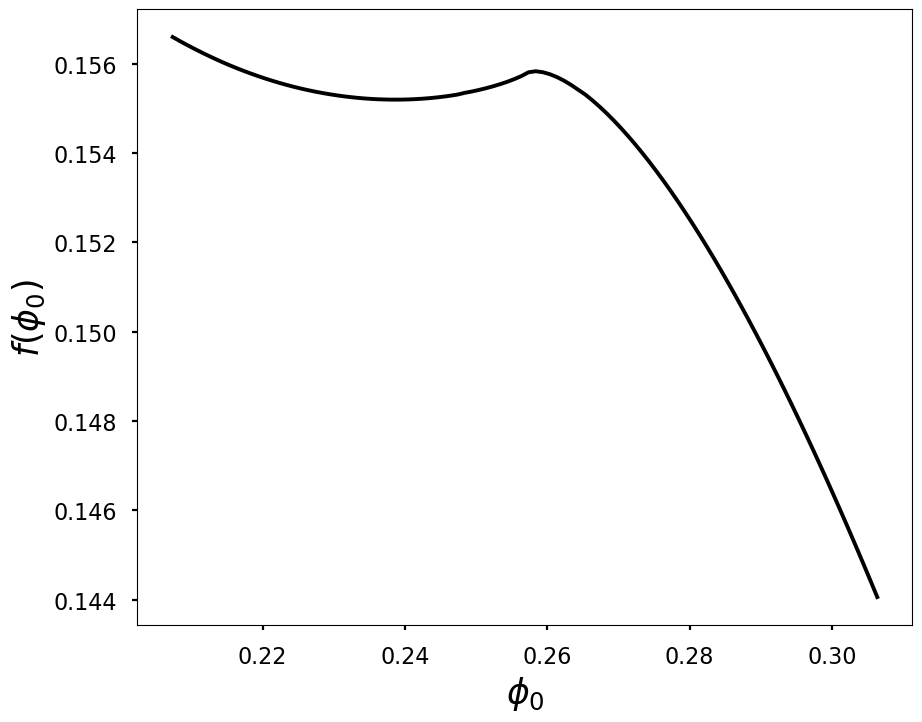

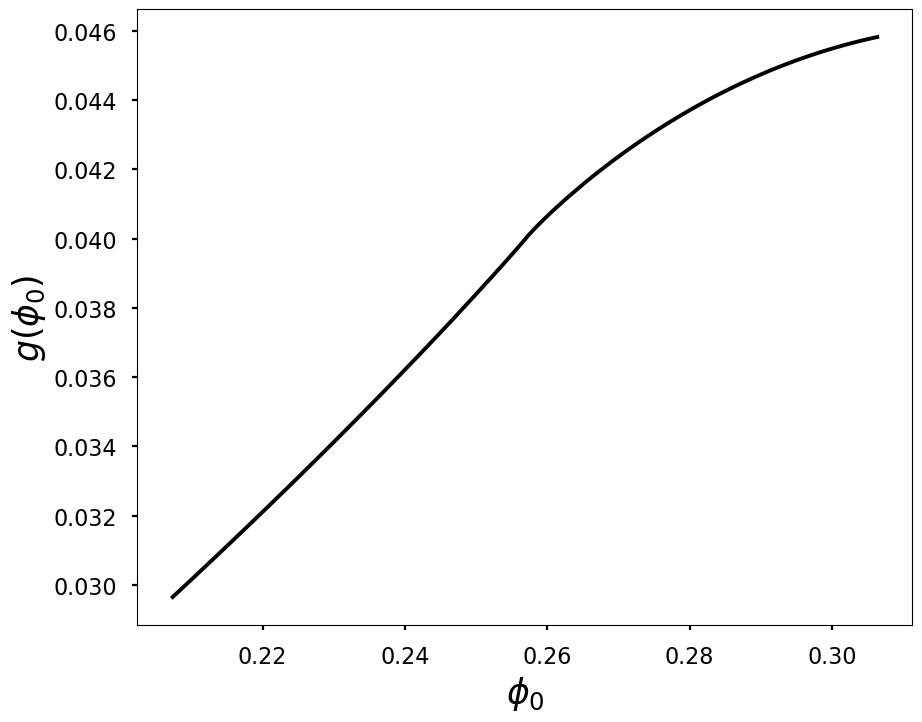

In [62]:
f_crit_dfm, g_crit_dfm,phi0s_crit_dfm = compute_critical_fluxes(full_DFM,phi_c_dfm)

100%|██████████| 100/100 [01:58<00:00,  1.18s/it]


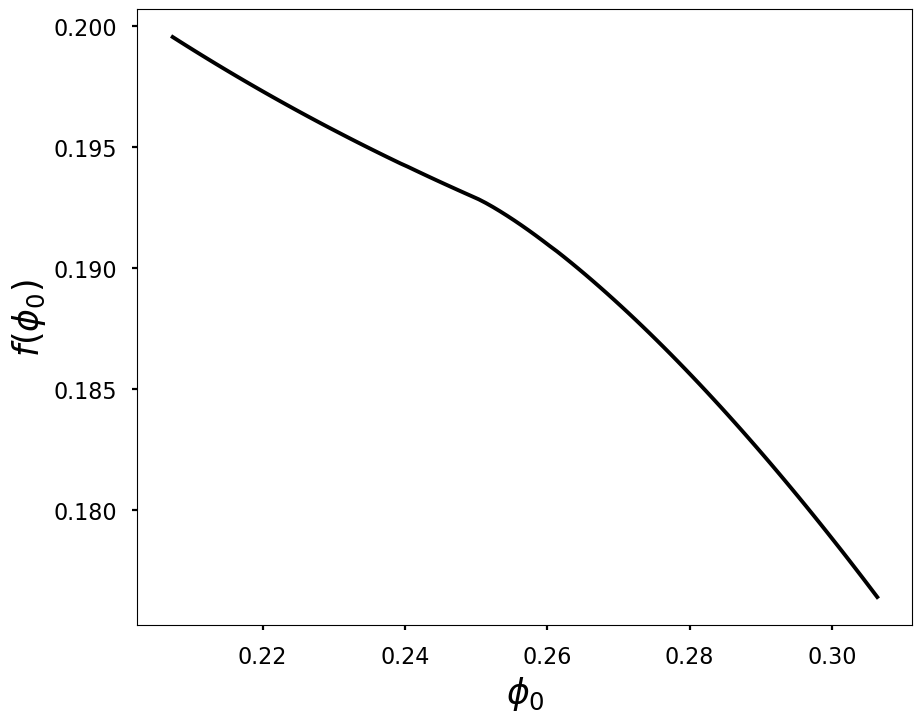

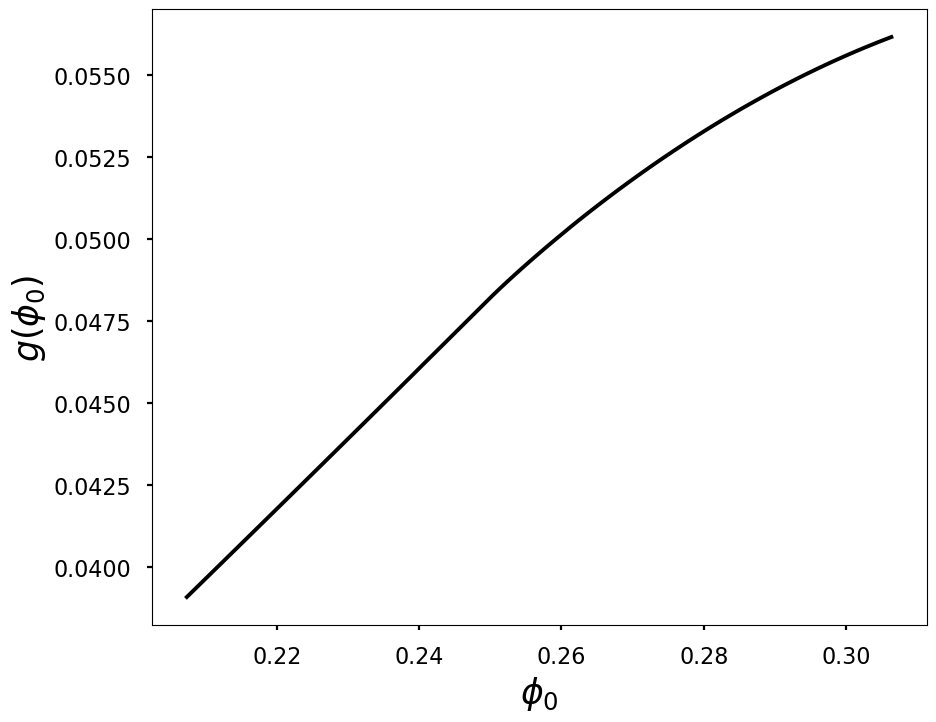

In [63]:
f_crit_sbm, g_crit_sbm,phi0s_crit_sbm = compute_critical_fluxes(full_SBM,phi_c_sbm)

100%|██████████| 100/100 [06:01<00:00,  3.62s/it]


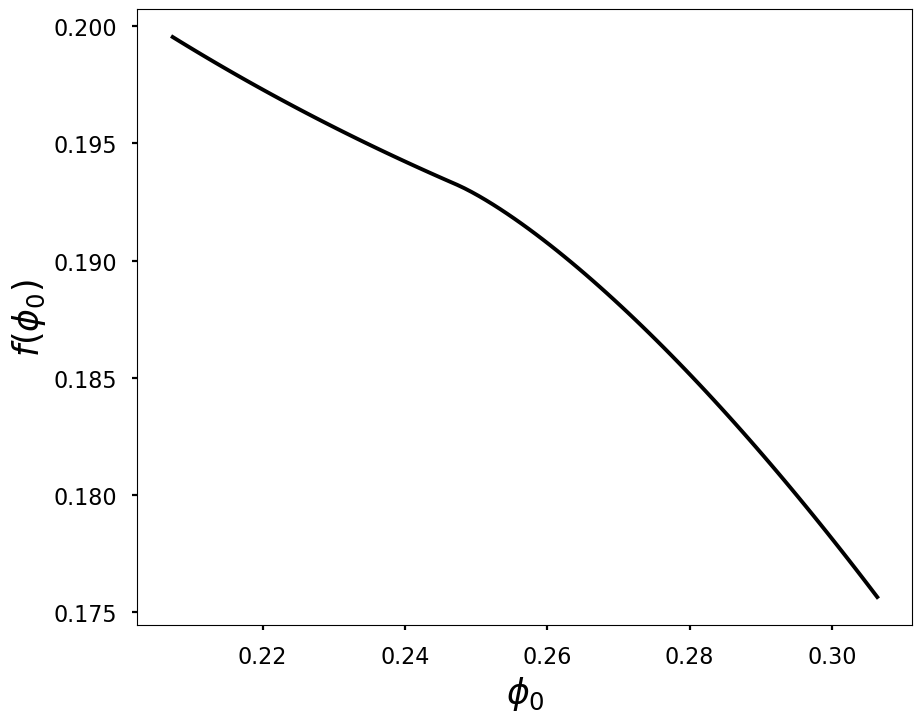

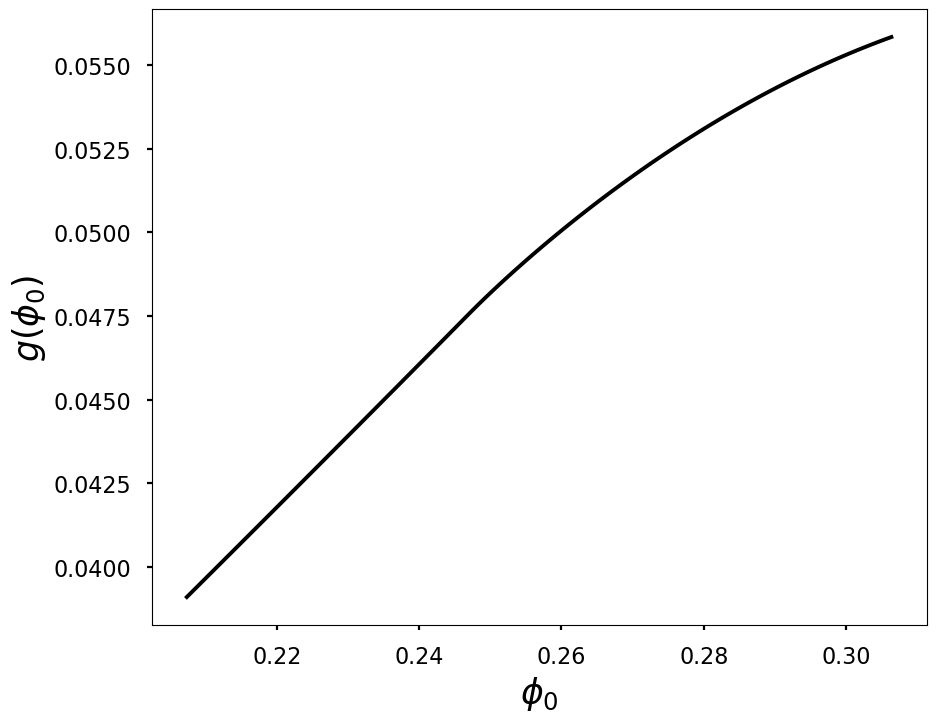

In [64]:
f_crit_sbm_corr, g_crit_sbm_corr,phi0s_crit_sbm_corr = compute_critical_fluxes(full_SBM_shear_rate_corr,phi_c_sbm)

In [65]:
#f_sbm,g_sbm,f_dfm,g_dfm
print(phi0s_crit_dfm[50],phi_c_dfm)
#print(phi0s_crit_sbm[50],phi_c_sbm)
print(phi0s_crit_sbm_corr[50],phi_c_sbm)

critical_fluxes = [f_crit_sbm_corr[50],g_crit_sbm_corr[50],f_crit_dfm[50],g_crit_dfm[50]]
print(critical_fluxes)


0.2573622342146197 0.2573622342146197
0.2573622342146197 0.2573622342146197
[0.19135449503105048, 0.04958930501266069, 0.15580469409379594, 0.04009824592094739]


In [66]:
import pickle, os

path = dir_path +'angle'+str(angle)+'/'

try:
    os.mkdir(path)
except:
    print('Directory exists:', path)

file_name='critical_fluxes'+str(angle)

with open(path+file_name, "wb") as f:
    pickle.dump(critical_fluxes, f)

Directory exists: flux_tables/angle60/
